# Project 4: Football matches as mobility networks
During a football match, players move on the field to attack and defend. This generates a series of movements that can be analyzed to understand the players behavior.<br><br>
The student should use the `Wyscout open dataset`, describing the “events” in all matches of seven competitions (e.g., passes, shots, tackles etc.), to analyze pass chains and the mobility of football players. A player’s movement is defined by consecutive events made by that player in the match.<br><br>
- Investigate the distances traveled by players during their matches and their distributions. Discuss about the similarity of these distributions with those about mobility trajectories seen during the course.<br><br>
- Relate the pass chains made by teams with the probability of making a shot, a goal, and to win a match. Are long chains more likely to lead to a shot/goal? Are short pass chains more successful?<br><br>
- <b>Quantify the predictability of pass chains based on some division of the football field (tessellation). To what extent can we predict the next tile (field zone) where the ball will be? Use a next-location predictor to quantify the accuracy to predict the next zone the ball will be.</b>

In [1]:
import json
import pandas as pd
import numpy as np
import random
from utils import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

### Data load

In [2]:
""" # loading the events data
events={}
nations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for nation in nations:
    with open('./data/events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data) """

" # loading the events data\nevents={}\nnations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']\nfor nation in nations:\n    with open('./data/events/events_%s.json' %nation) as json_data:\n        events[nation] = json.load(json_data) "

### JSON to DataFrame

In [3]:
""" events_df = {
    'Italy': pd.DataFrame(events['Italy']),
    'England': pd.DataFrame(events['England']),
    'Germany': pd.DataFrame(events['Germany']),
    'France': pd.DataFrame(events['France']),
    'Spain': pd.DataFrame(events['Spain']),
    'European_Championship': pd.DataFrame(events['European_Championship']),
    'World_Cup': pd.DataFrame(events['World_Cup'])
} """

" events_df = {\n    'Italy': pd.DataFrame(events['Italy']),\n    'England': pd.DataFrame(events['England']),\n    'Germany': pd.DataFrame(events['Germany']),\n    'France': pd.DataFrame(events['France']),\n    'Spain': pd.DataFrame(events['Spain']),\n    'European_Championship': pd.DataFrame(events['European_Championship']),\n    'World_Cup': pd.DataFrame(events['World_Cup'])\n} "

In [4]:
""" for championship in events_df:
    if (championship == 'European_Championship') or (championship == 'World_Cup'):
        events_df[championship] = events_df[championship][events_df[championship]['matchPeriod'] != 'P']
    events_df[championship] = events_df[championship][(events_df[championship]['eventId'] != 1) & (~events_df[championship]['subEventId'].isin([11, 12]))].reset_index(drop=True)
    events_df[championship] = events_df[championship][(events_df[championship]['subEventName'] != 'Goal kick')].reset_index(drop=True)
    events_df[championship].drop(columns=['tags', 'eventName', 'subEventId', 'id'], inplace=True) """

" for championship in events_df:\n    if (championship == 'European_Championship') or (championship == 'World_Cup'):\n        events_df[championship] = events_df[championship][events_df[championship]['matchPeriod'] != 'P']\n    events_df[championship] = events_df[championship][(events_df[championship]['eventId'] != 1) & (~events_df[championship]['subEventId'].isin([11, 12]))].reset_index(drop=True)\n    events_df[championship] = events_df[championship][(events_df[championship]['subEventName'] != 'Goal kick')].reset_index(drop=True)\n    events_df[championship].drop(columns=['tags', 'eventName', 'subEventId', 'id'], inplace=True) "

In [5]:
""" for nation in nations:
    events_df[nation]['positions'] = events_df[nation]['positions'].apply(lambda x: from_coords_to_tesselation(x))
    events_df[nation].rename(columns={'positions': 'tessellation'}, inplace=True) """

" for nation in nations:\n    events_df[nation]['positions'] = events_df[nation]['positions'].apply(lambda x: from_coords_to_tesselation(x))\n    events_df[nation].rename(columns={'positions': 'tessellation'}, inplace=True) "

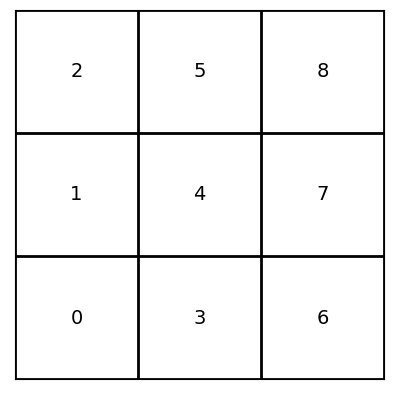

In [6]:
draw_pitch_tessellation()

In [7]:
""" pass_chains = {}

current_team_id = None
current_pass_chain = []
last_pass_event_index = {}

for nation in nations:
    for index, row in events_df[nation].iterrows():
        if row['eventId'] in [3, 8]:
            if row['teamId'] != current_team_id:
                if current_pass_chain:
                    pass_chains[index] = current_pass_chain
                current_team_id = row['teamId']
                current_pass_chain = [row['tessellation']]
                last_pass_event_index[current_team_id] = index
            else:
                current_pass_chain.append(row['tessellation'])
                last_pass_event_index[current_team_id] = index
        else:
            if row['teamId'] != current_team_id:
                if current_pass_chain:
                    pass_chains[last_pass_event_index[current_team_id]] = current_pass_chain
                current_team_id = row['teamId']
                current_pass_chain = []

if current_pass_chain:
    pass_chains[last_pass_event_index[current_team_id]] = current_pass_chain """

" pass_chains = {}\n\ncurrent_team_id = None\ncurrent_pass_chain = []\nlast_pass_event_index = {}\n\nfor nation in nations:\n    for index, row in events_df[nation].iterrows():\n        if row['eventId'] in [3, 8]:\n            if row['teamId'] != current_team_id:\n                if current_pass_chain:\n                    pass_chains[index] = current_pass_chain\n                current_team_id = row['teamId']\n                current_pass_chain = [row['tessellation']]\n                last_pass_event_index[current_team_id] = index\n            else:\n                current_pass_chain.append(row['tessellation'])\n                last_pass_event_index[current_team_id] = index\n        else:\n            if row['teamId'] != current_team_id:\n                if current_pass_chain:\n                    pass_chains[last_pass_event_index[current_team_id]] = current_pass_chain\n                current_team_id = row['teamId']\n                current_pass_chain = []\n\nif current_pass_chain:

In [8]:
import pickle

""" passes = open('pass_chains.pkl', 'wb') 
pickle.dump(pass_chains, passes) """

" passes = open('pass_chains.pkl', 'wb') \npickle.dump(pass_chains, passes) "

In [9]:
with open('pass_chains.pkl', 'rb') as passes:
    pass_chains = pickle.load(passes)

In [10]:
# deletes the pairs key-value with a length of the value less than 2
pass_chains = [chain for chain in pass_chains.values() if len(chain) > 1]

### Recurrent Neural Network

In [11]:
# Determine maximum sequence length
max_length = max(len(seq) for seq in pass_chains)

# Pad sequences
padded_data = pad_sequences(pass_chains, maxlen=max_length, padding='post', value=0)

# One-hot encode if needed (assuming the data is categorical)
one_hot_data = to_categorical(padded_data)

In [15]:
print('Lunghezza massima di una sequenza:', max_length)

Lunghezza massima di una sequenza: 83


In [16]:
# Remove the last value (target variable) from each sequence
from numpy import shape


X = one_hot_data[:, :-1, :]  # Features (input data)
y = one_hot_data[:, -1, :]   # Target variable (to be predicted)

# Split the data into training, validation, and test sets
# For example, you can use an 80-10-10 split
num_samples = len(X)
train_size = int(0.6 * num_samples)
val_size = int(0.2 * num_samples)

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

print('Shape of the training set:', shape(X_train))
print('Shape of the validation set:', shape(X_val))
print('Shape of the test set:', shape(X_test))
print('Shape of the training labels:', shape(y_train))
print('Shape of the validation labels:', shape(y_val))
print('Shape of the test labels:', shape(y_test))

Shape of the training set: (121670, 82, 9)
Shape of the validation set: (40556, 82, 9)
Shape of the test set: (40558, 82, 9)
Shape of the training labels: (121670, 9)
Shape of the validation labels: (40556, 9)
Shape of the test labels: (40558, 9)


In [13]:
def create_model(units=64, optimizer='adam', model__neurons=16):
    model = Sequential()
    if(type(model__neurons) == tuple):
        for num in model__neurons:
            model.add(SimpleRNN(units=num, input_shape=(max_length-1, one_hot_data.shape[2])))
    else:
        model.add(SimpleRNN(units=model__neurons, input_shape=(max_length-1, one_hot_data.shape[2])))
    model.add(Dense(units=y.shape[1], activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
#Dovrei fare anche la grid search sul learning rate, momentum e altro? Su quali parametri fare la grid search?
batch_size = [10, 50, 100]
epochs = [10, 50, 100]
neurons = [5, 10, (5, 5), (5, 10), (10, 5)]
param_grid = dict(batch_size=batch_size, epochs=epochs, model__neurons=neurons)

model = KerasClassifier(build_fn=create_model, verbose=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 45 candidates, totalling 135 fits
